# Homework 2 - IEEE Fraud Detection

### **Import Libraries**

In [0]:
# Upload Data from Kaggle
#! pip install -q kaggle
#from google.colab import files

# Upload Data from Google Drive
from google.colab import drive

# Store Data in Pandas Dataframe
import pandas as pd

# Numerical functions
import numpy as np

# For Correlation Coefficients
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
tips = sns.load_dataset("tips")
sns.set(style='whitegrid', palette="deep", font_scale=1.1)

# Convert date to required format
import datetime

# Format data using HTML
from IPython.display import display_html 

# Model
from sklearn.linear_model import LogisticRegression
import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# For ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# For Image
from google.colab import files
from IPython.display import Image

### **Mount Data**

In [33]:
### From Google Drive

# Mount drive at location
drive.mount('/content/drive')

# Get file paths from mounted location
train_transaction_path = "/content/drive/My Drive/Fall 2019/CSE 519 - DSF/HW 2 - Fraud Detection/Dataset/train_transaction.csv"
train_identity_path = "/content/drive/My Drive/Fall 2019/CSE 519 - DSF/HW 2 - Fraud Detection/Dataset/train_identity.csv"
test_transaction_path = "/content/drive/My Drive/Fall 2019/CSE 519 - DSF/HW 2 - Fraud Detection/Dataset/test_transaction.csv"
test_identity_path = "/content/drive/My Drive/Fall 2019/CSE 519 - DSF/HW 2 - Fraud Detection/Dataset/test_identity.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Read CSV and store in Pandas Dataframe
df1 = pd.read_csv(train_transaction_path)
df2 = pd.read_csv(train_identity_path)

### **Data Processing**

In [0]:
# Drop unwanted columns

# train_transaction_data:
cols = list(range(17,394))
df1.drop(df1.columns[cols], axis =1, inplace=True)
cols = [5,6,7,9]
df1.drop(df1.columns[cols], axis =1, inplace=True)

# train_identity_data:
cols=list(range(1,39))
df2.drop(df2.columns[cols], axis =1, inplace=True)#drop second and third columns

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

### **Filter for Fraudulent and Non-Fradulent Data**

In [0]:
#Filter for Non-Fraudulent
nonfraud_df = df1.query("isFraud==0")

# Filter for Fraudulent
fraud_df = df1.query("isFraud==1")

### **Transaction Date**

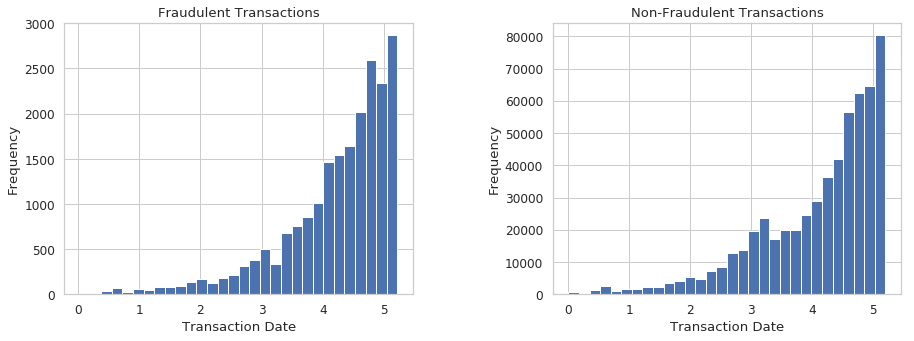

In [37]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
sns.distplot(
    np.log(fraud_df['TransactionDT']/(3600*24)), norm_hist=False, kde=False, bins=30, hist_kws={"alpha": 1}
).set(xlabel='Transaction Date', ylabel='Frequency', title='Fraudulent Transactions');

ax = fig.add_subplot(1, 2, 2)
sns.distplot(
    np.log(nonfraud_df['TransactionDT']/(3600*24)), norm_hist=False, kde=False, bins=30, hist_kws={"alpha": 1}
).set(xlabel='Transaction Date', ylabel='Frequency', title='Non-Fraudulent Transactions');

plt.show()

The plot above shows the log of the transaction date frequency in order to better understand the distribution. It shows the rate of increase in the number of transactions per day. The rate of increase is similar for fraudulent as well as non-fradulent transactions.

### **Transaction Amount**

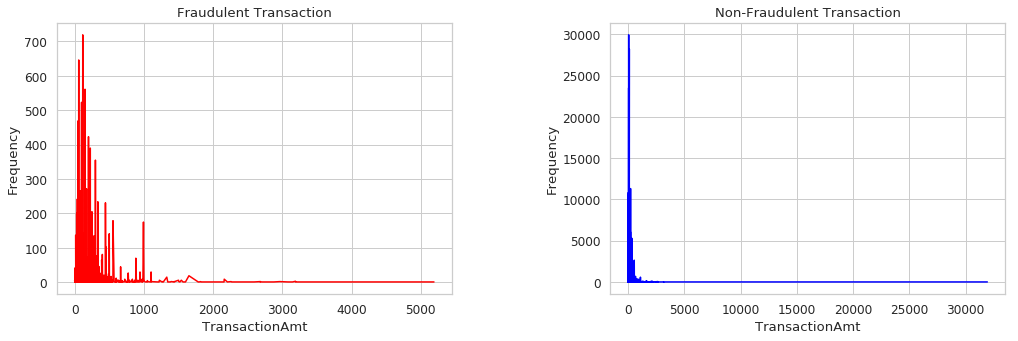

In [38]:
# Count number of transactions for different transaction amounts
fraud_count  = fraud_df['TransactionAmt'].value_counts()
nfraud_count  = nonfraud_df['TransactionAmt'].value_counts()

fig = plt.figure(figsize=(17,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
sns.lineplot(x=fraud_count.index, y=fraud_count.values, color="red").set(xlabel='TransactionAmt', ylabel='Frequency', title='Fraudulent Transaction');
ax = fig.add_subplot(1, 2, 2)
sns.lineplot(x=nfraud_count.index, y=nfraud_count.values, color="blue").set(xlabel='TransactionAmt', ylabel='Frequency', title='Non-Fraudulent Transaction');

plt.show()

The frequency of Non-Fraud Transactions is much more than the Fraud Transactions. 

We can see that the Non-Fraud Transactions range only till 5000 and most of the fraud transactions are in the lower range of 1-1000. There are few fraud transactions of the amount between 1000-2000. Therefore, above the amount 2000, most probability of fraud transactions is very low.

### **Product Code**

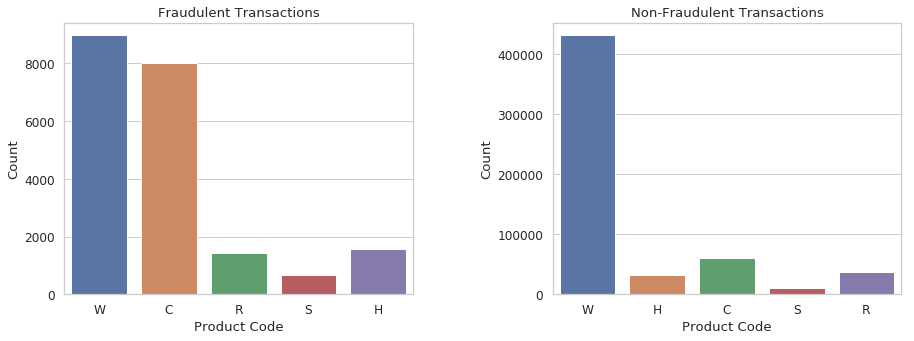

In [39]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
sns.countplot(data=fraud_df,x='ProductCD').set(xlabel='Product Code', ylabel='Count', title='Fraudulent Transactions');
ax = fig.add_subplot(1, 2, 2)
sns.countplot(data=nonfraud_df,x='ProductCD').set(xlabel='Product Code', ylabel='Count', title='Non-Fraudulent Transactions');

plt.show()

The Product with code 'W' has the highest frequency in the dataset. The frequency of product with code 'C' is very less compared to 'W', yet the fraud transactions for that product is only a little less compared to 'W'. Therefore, the product 'C' has a high probablity of fraudulent transaction. 

### **Card - Issuer & Type**

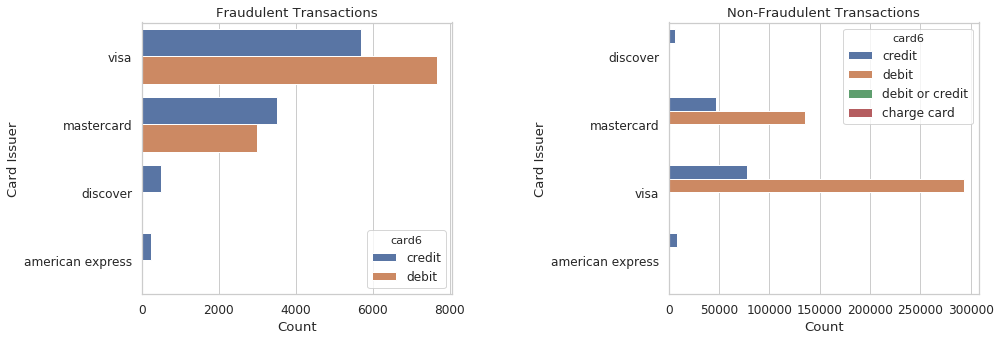

In [40]:
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.7)

ax = fig.add_subplot(1, 2, 1)
sns.countplot(data=fraud_df,y='card4', hue='card6').set(xlabel='Count', ylabel='Card Issuer', title='Fraudulent Transactions');
ax = fig.add_subplot(1, 2, 2)
sns.countplot(data=nonfraud_df,y='card4', hue='card6').set(xlabel='Count', ylabel='Card Issuer', title='Non-Fraudulent Transactions');

plt.show()

Visa card is most frequently used. Within the visa cards, the debit card usage frequency is much higher as compared to the credit card usage. Yet the difference in the fraudulent transactions is not much. Therefore, the probability of having a fraud transaction using a Visa Credit card is high.

Similarly, in Mastercards as well, the credit card usage for fraud transactions is much higher as compared to the debit cards.

### **Billing Region**

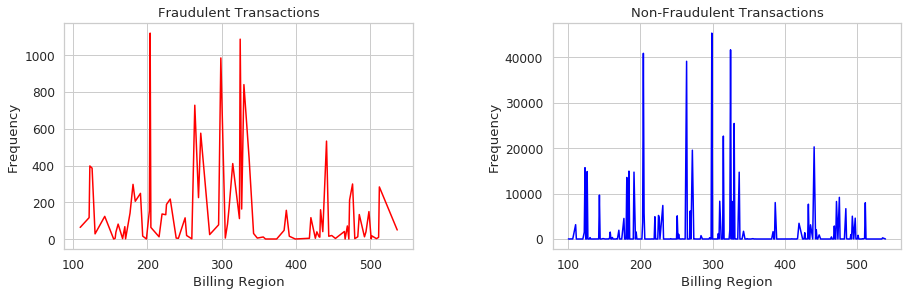

In [41]:
fraud_count  = fraud_df['addr1'].value_counts()
nfraud_count  = nonfraud_df['addr1'].value_counts()

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
sns.lineplot(x=fraud_count.index, y=fraud_count.values, color="red").set(xlabel='Billing Region', ylabel='Frequency', title='Fraudulent Transactions');
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(x=nfraud_count.index, y=nfraud_count.values, color="blue").set(xlabel='Billing Region', ylabel='Frequency', title='Non-Fraudulent Transactions');

plt.show()

### **Billing Country**

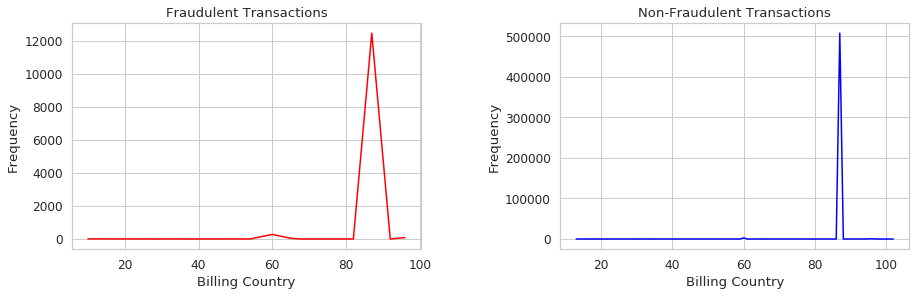

In [42]:
fraud_count  = fraud_df['addr2'].value_counts()
nfraud_count  = nonfraud_df['addr2'].value_counts()

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(2, 2, 1)
sns.lineplot(x=fraud_count.index, y=fraud_count.values, color="red").set(xlabel='Billing Country', ylabel='Frequency', title='Fraudulent Transactions');
ax = fig.add_subplot(2, 2, 2)
sns.lineplot(x=nfraud_count.index, y=nfraud_count.values, color="blue").set(xlabel='Billing Country', ylabel='Frequency', title='Non-Fraudulent Transactions');

plt.show()

### **Distance measurement**

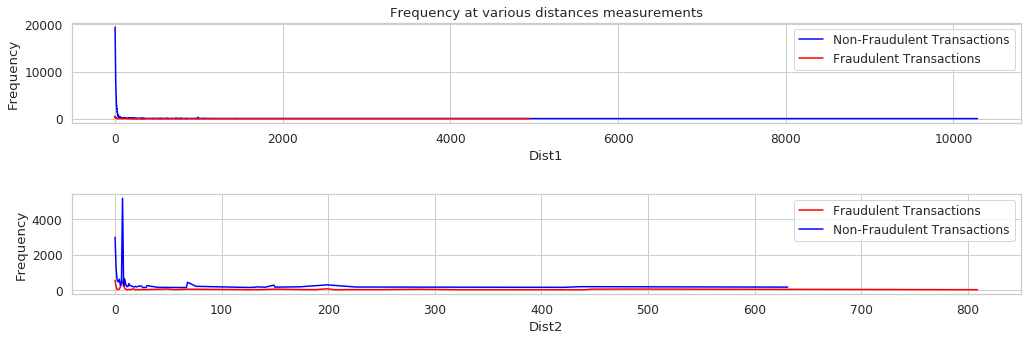

In [43]:
fig = plt.figure(figsize=(17,5))
fig.subplots_adjust(hspace=0.7, wspace=0.4)

# Frequency Count for dist1
fraud_count  = fraud_df['dist1'].value_counts()
nfraud_count  = nonfraud_df['dist1'].value_counts()

# Plot dist1
ax = fig.add_subplot(2, 1, 1)
sns.lineplot(x=nfraud_count.index, y=nfraud_count.values, color="blue", label="Non-Fraudulent Transactions")
sns.lineplot(x=fraud_count.index, y=fraud_count.values, color="red", label="Fraudulent Transactions").set(xlabel='Dist1', ylabel='Frequency', title='Frequency at various distances measurements');

# Frequency Count for dist2
fraud_count = 0
nfraud_count = 0
fraud_count  = fraud_df['dist2'].value_counts()
fraud_count = fraud_count[:40,]
nfraud_count  = nonfraud_df['dist2'].value_counts()
nfraud_count = nfraud_count[:40,]

# Plot dist2
ax = fig.add_subplot(2, 1, 2)
sns.lineplot(x=fraud_count.index, y=fraud_count.values, color="red", label="Fraudulent Transactions")
sns.lineplot(x=nfraud_count.index, y=nfraud_count.values, color="blue", label="Non-Fraudulent Transactions").set(xlabel='Dist2', ylabel='Frequency');

plt.show()

For dist1, the highest probability of non-fraud traansactions is close to dist 0. While for the rest of the distances, the fraud and non-fraud probability is simliar. After the distance 5000, only non-fraud exists i.e. fraud transaction probability is very low.

For dist2, in range from 0-20 approximately, the probability of non-fraud is very high. While from 20-650 has both fraud and non-fraud transactions exist with non-fraud being a little higher than fraud. After 600, there is high probability of fraud transaction as we cannot se non-fraud transactions in that range.

### **Email Domain of Purchaser V/s Recepient**

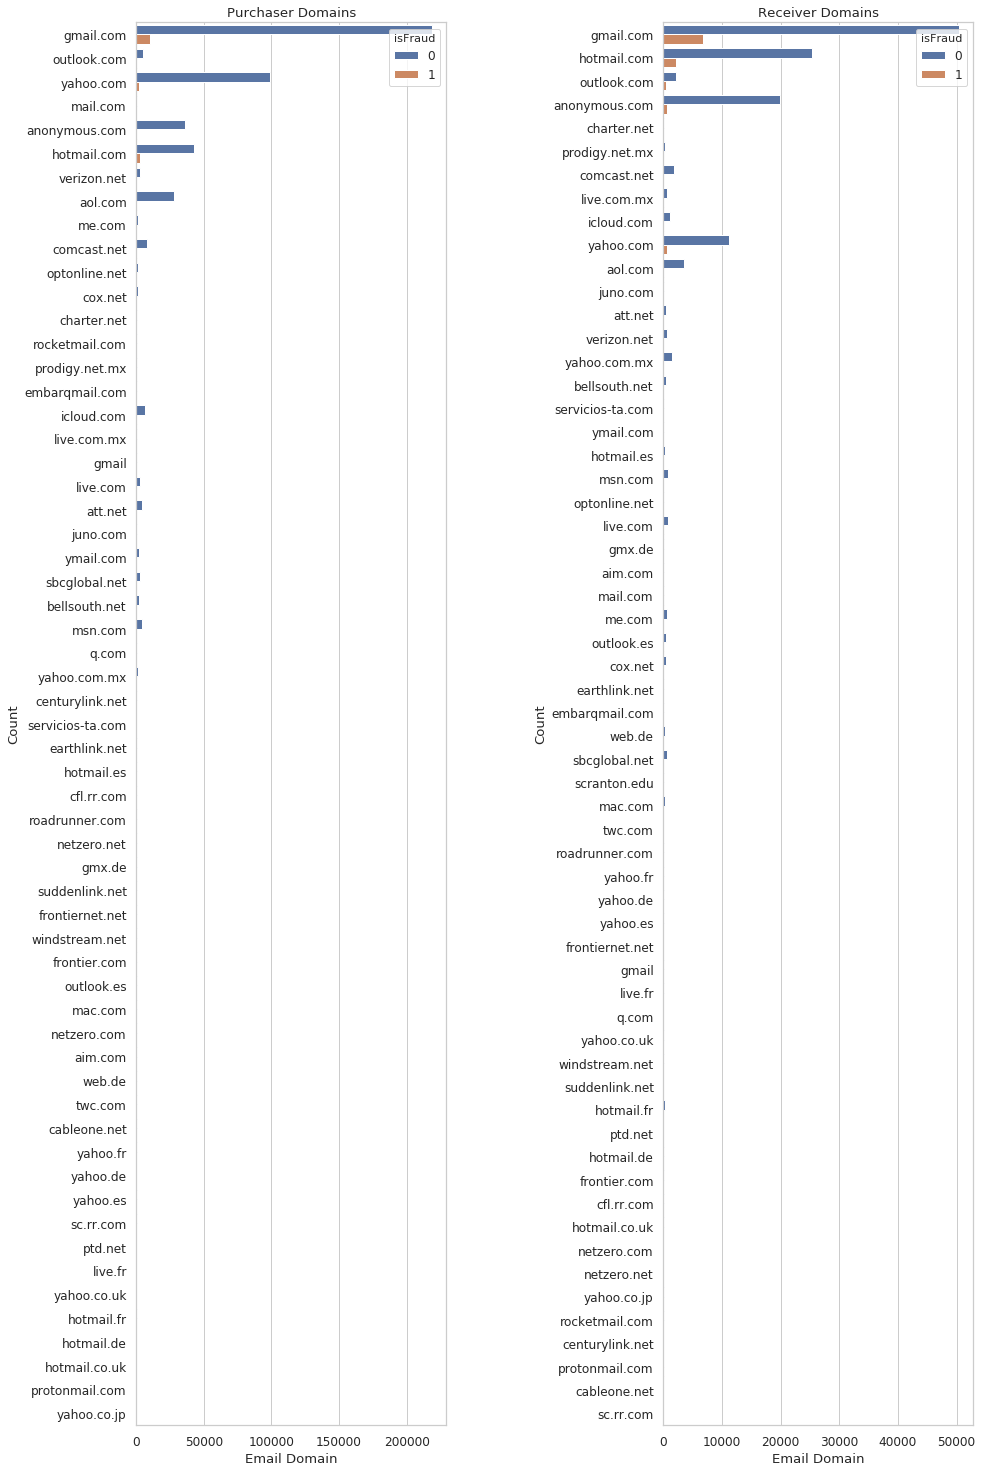

In [44]:
fig = plt.figure(figsize=(15,80))
fig.subplots_adjust(hspace=1.1, wspace=0.7)

ax = fig.add_subplot(2, 2, 1)
sns.countplot(data=df1,y='P_emaildomain',hue='isFraud').set(xlabel='Email Domain', ylabel='Count', title='Purchaser Domains');
ax = fig.add_subplot(2, 2, 2)
sns.countplot(data=df1,y='R_emaildomain',hue='isFraud').set(xlabel='Email Domain', ylabel='Count', title='Receiver Domains');

plt.show()

The most frequent domains are gmail.com, yahoo.com, outlook.com, hotmail.com, aol.com, anonymous.com and few others. Out of these, gmail.com is used the most and hence, we can see significant fraud transactions using this domain.

In the receiver email domain, hotmail.com also has a significant frequency after gmail.com and hence, we can see a good number of fraud transactions using hotmail too.


### **Device Type**

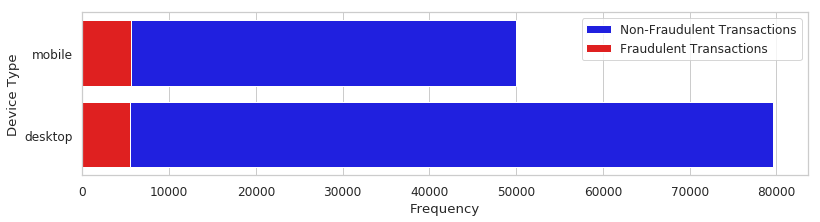

In [45]:
# Merge transaction and identity datasets
merged_df = pd.merge(df1, df2)
f_merged_df = merged_df.query("isFraud==1")
nf_merged_df = merged_df.query("isFraud==0")

fig = plt.figure(figsize=(13,3))
sns.countplot(y=nf_merged_df['DeviceType'], color="blue", label="Non-Fraudulent Transactions")
g = sns.countplot(y=f_merged_df['DeviceType'], color="red", label="Fraudulent Transactions")
g.set(ylabel='Device Type', xlabel='Frequency');
g.legend(loc="upper right")
plt.show()

Desktops are more frequently used for transactions as compared to mobile devices. Yet, the number of fraud transactions for desktop and mobile look similar. Therefore, there is a higher probability of a mobile device performing fraudulent transactions. 

### **Device Info**

In [46]:
# Calculate frequency of each element in DeviceInfo
fraud_count  = f_merged_df['DeviceInfo'].value_counts()
nfraud_count  = nf_merged_df['DeviceInfo'].value_counts()

temp_f_df = (pd.DataFrame({'DeviceInfo': fraud_count.index, 'Count':fraud_count.values})).query('Count>100')
temp_nf_df = pd.DataFrame({'DeviceInfo': nfraud_count.index, 'Count':nfraud_count.values}).query('Count>500')

# Show data in a table
df1_styler = temp_f_df.style.set_table_attributes("style='display:inline'").set_caption('Fraud Transactions')
df2_styler = temp_nf_df.style.set_table_attributes("style='display:inline'").set_caption('Non-Fraud Transactions')

display_html(df1_styler._repr_html_()
             +"&nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp"
             +df2_styler._repr_html_(), raw=True)

,DeviceInfo,Count
0,Windows,3121
1,iOS Device,1240
2,MacOS,278
3,hi6210sft Build/MRA58K,180
4,SM-A300H Build/LRX22G,169
5,rv:57.0,103
,DeviceInfo,Count
0,Windows,44601
1,iOS Device,18542
2,MacOS,12295


## Part 2 - Transaction Frequency

In [47]:
# Get most frequent country code
cntry_count  = df1['addr2'].value_counts()
pd.DataFrame(cntry_count.values, cntry_count.index, columns=["Frequency"])

,Frequency
87.0,520481
60.0,3084
96.0,638
32.0,91
65.0,82
16.0,55
31.0,47
19.0,33
26.0,25
27.0,20


This table gives the frequency of transactions for every country. From this we can see that country with code = 87.0 has highest frequency of transactions.

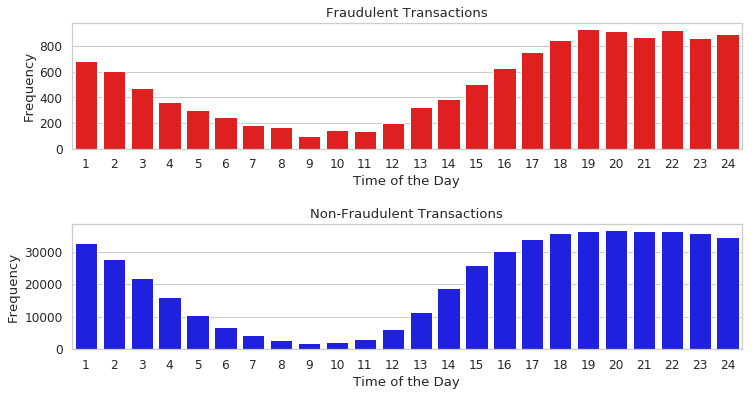

In [48]:
# Format TransactionDT to required format (Reference: https://www.kaggle.com/c/ieee-fraud-detection/discussion/102157#latest-589162)
df1['TransactionDT'].head() 
start_date = '2016-01-01'
startdate = datetime.datetime.strptime(start_date, '%Y-%m-%d') 
df1['TransactionDT_temp'] = df1['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
df1['TransactionDThours'] = df1['TransactionDT_temp'].dt.hour
del df1['TransactionDT_temp']

#Filter for Fraudulent & Non-Fraudulent (Addr=87.0)
time_f_df = df1.query("addr2==87.0 & isFraud==1")
time_nf_df = df1.query("addr2==87.0 & isFraud==0")

# Transactions based on hour of the day
fraud_count  = time_f_df['TransactionDThours'].value_counts()
fraud_count = fraud_count[:40,]
nfraud_count  = time_nf_df['TransactionDThours'].value_counts()
nfraud_count = nfraud_count[:40,]

# Plot
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

ax = fig.add_subplot(2, 1, 1)
sns.barplot(x=(fraud_count.index)+1, y=fraud_count.values, color="red").set(xlabel='Time of the Day', ylabel='Frequency', title='Fraudulent Transactions');
ax = fig.add_subplot(2, 1, 2)
sns.barplot(x=(nfraud_count.index)+1, y=nfraud_count.values, color="blue").set(xlabel='Time of the Day', ylabel='Frequency', title='Non-Fraudulent Transactions');

plt.show()

Both the Fraud and Non-Fraud Transaction graphs have a similar pattern and hence, we can understand the waking hours of this country with code = 87.0.

According to this plot, the number of transaction decreases between 

## Part 3 - Product Code

In [49]:
# Get frequency and mean of each product code
mean = [(df1.query("ProductCD=='W'"))['TransactionAmt'].mean(), 
        (df1.query("ProductCD=='C'"))['TransactionAmt'].mean(),
        (df1.query("ProductCD=='R'"))['TransactionAmt'].mean(),
        (df1.query("ProductCD=='H'"))['TransactionAmt'].mean(),
        (df1.query("ProductCD=='S'"))['TransactionAmt'].mean()]
count  = df1['ProductCD'].value_counts()

pd.DataFrame({'ProductCode': count.index, 'Frequency':count.values, 'Mean': mean})

,ProductCode,Frequency,Mean
0,W,439670,153.158554
1,C,68519,42.872353
2,R,37699,168.306188
3,H,33024,73.170058
4,S,11628,60.269487


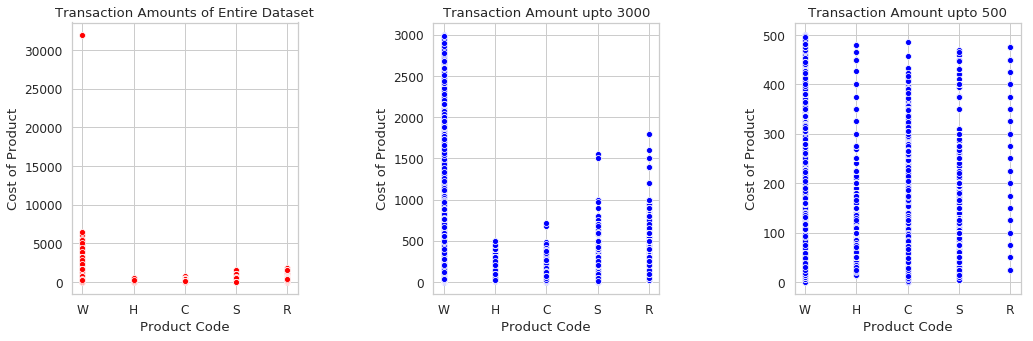

In [50]:
# Plot
fig = plt.figure(figsize=(17,5))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

ax = fig.add_subplot(1, 3, 1)
sns.scatterplot(data=df1, x="ProductCD", y="TransactionAmt", color="red").set(xlabel='Product Code', ylabel='Cost of Product', title='Transaction Amounts of Entire Dataset');
ax = fig.add_subplot(1, 3, 2)
temp_df = df1.query('TransactionAmt<3000')
sns.scatterplot(data=temp_df, x="ProductCD", y="TransactionAmt", color="blue").set(xlabel='Product Code', ylabel='Cost of Product', title='Transaction Amount upto 3000');
ax = fig.add_subplot(1, 3, 3)
temp_df = df1.query('TransactionAmt<500')
sns.scatterplot(data=temp_df, x="ProductCD", y="TransactionAmt", color="blue").set(xlabel='Product Code', ylabel='Cost of Product', title='Transaction Amount upto 500');

plt.show()

Most Expensive Product - W

Most Cheapest Product - C

Explanation:

The first scatter plot consists of the entire dataset. All products other than 'W' have costs below 2000, while product 'W' has cost upto 7000 approximately and it has one product priced at 30,0000. Therefore, from this plot, it is evident that the product with code 'W' has the most expensive products. 

In the second scatter plot, we have limited the cost upto 3000 so as to get a clear view of the other products with lower costs. Here, products 'H' and 'C', have similar plots with the exception of 2 items with higher cost in 'C'. 

The third plot is limited to transaction amounts less than 500, so that we can comapre the frequency of 'H' and 'C'. From the above frequency table we can see that 'C' has a very high frequency as compared to 'H' i.e. frequency of 'C' is approximately double of 'H'. This means that 'C' has larger number of products in the range upto 500 as compared to 'H'. 

Therefore, even the mean transaction amount of 'C' as found above, is less than the mean transaction amount of 'H'. This confirms that 'C' is the cheapest product.

## Part 4 - Correlation Coefficient

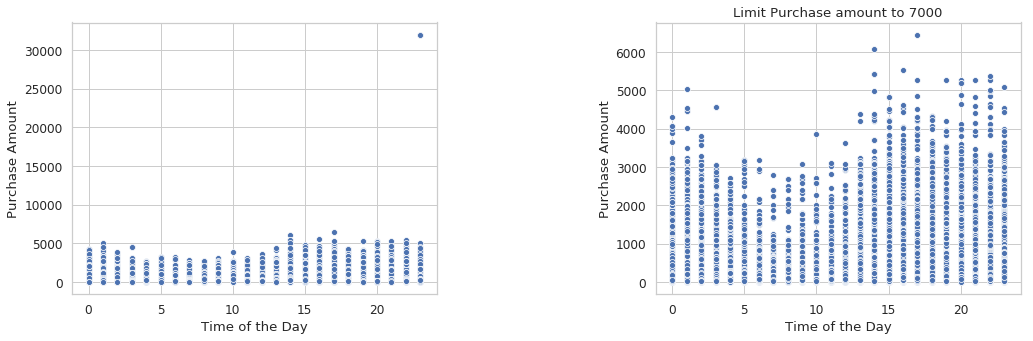

In [51]:
# Plot
fig = plt.figure(figsize=(17,5))
fig.subplots_adjust(hspace=0.6, wspace=0.6)

ax = fig.add_subplot(1, 2, 1)
sns.scatterplot(data=df1, x="TransactionDThours", y="TransactionAmt").set(xlabel='Time of the Day', ylabel='Purchase Amount');
ax = fig.add_subplot(1, 2, 2)
temp_df = df1.query('TransactionAmt<7000')
sns.scatterplot(data=temp_df, x="TransactionDThours", y="TransactionAmt").set(xlabel='Time of the Day', ylabel='Purchase Amount', title='Limit Purchase amount to 7000');

plt.show()

From the second plot we can see that between the 5th-10th hour, the purchase amount of products is less compared to the rest of the day.

Other than this, we cannot see any correlation between the time of the day and the purchase amount. 

In [52]:
# Correlation Coefficients

corrP, _ = pearsonr(df1['TransactionDThours'], df1['TransactionAmt'])
print('Pearsons correlation: %.3f' % corrP)

corrS, _ = spearmanr(df1['TransactionDThours'], df1['TransactionAmt'])
print('Spearmans correlation: %.3f' % corrS)

Pearsons correlation: 0.045
Spearmans correlation: 0.038


Text(0.5, 1.0, 'Heatmap for Pearsons Correlation')

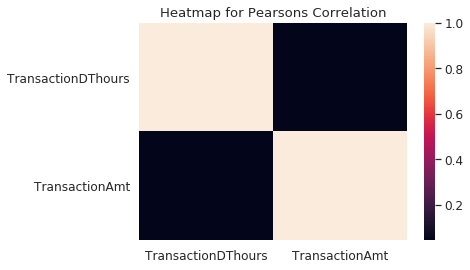

In [53]:
# Heatmap
g = sns.heatmap(df1[['TransactionDThours','TransactionAmt']].corr())
g.set_title('Heatmap for Pearsons Correlation')

The above correlation obtained by both methods confirms our conclusion from the plot. There is very less correlation between the hour of the day and the purchase amount.

## Part 5 - Interesting Plot

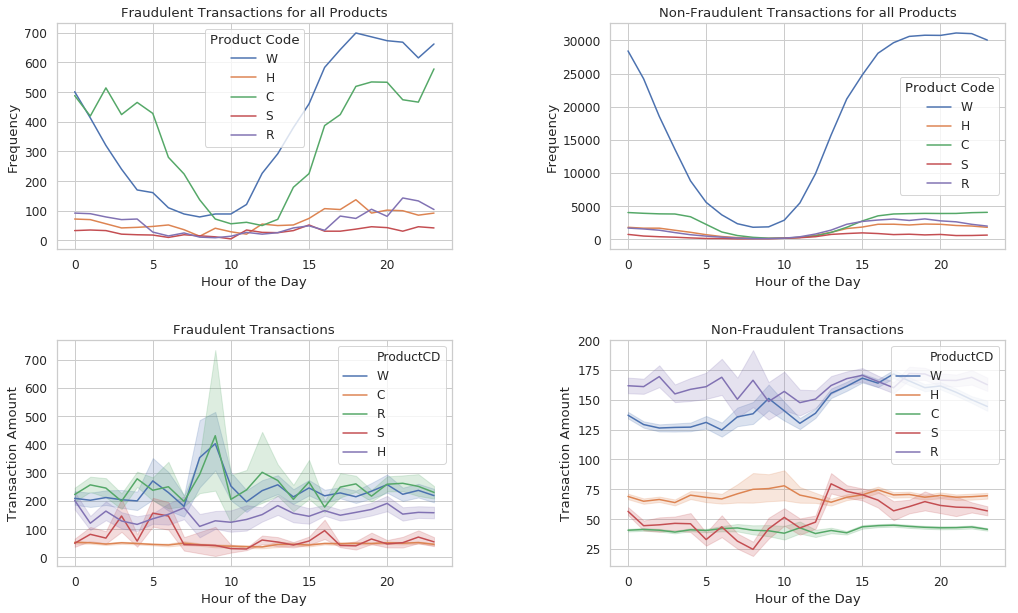

In [54]:
# Hour of the Day V/s Frequency of each Product

fig = plt.figure(figsize=(17,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Apply Filters
fraud_temp = df1.query("isFraud==1")
W_df = fraud_temp.query("ProductCD=='W'")
H_df = fraud_temp.query("ProductCD=='H'")
C_df = fraud_temp.query("ProductCD=='C'")
S_df = fraud_temp.query("ProductCD=='S'")
R_df = fraud_temp.query("ProductCD=='R'")

ax = fig.add_subplot(2, 2, 1)

count  = W_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="W")

count  = H_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="H")

count  = C_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="C")

count  = S_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="S")

count  = R_df['TransactionDThours'].value_counts()
g = sns.lineplot(x=count.index, y=count.values, label="R")
g.set(xlabel='Hour of the Day', ylabel='Frequency', title='Fraudulent Transactions for all Products')
g.legend_.set_title('Product Code')

# Apply Filters
nfraud_temp = df1.query("isFraud==0")
W_df = nfraud_temp.query("ProductCD=='W'")
H_df = nfraud_temp.query("ProductCD=='H'")
C_df = nfraud_temp.query("ProductCD=='C'")
S_df = nfraud_temp.query("ProductCD=='S'")
R_df = nfraud_temp.query("ProductCD=='R'")

ax = fig.add_subplot(2, 2, 2)

count  = W_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="W")

count  = H_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="H")

count  = C_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="C")

count  = S_df['TransactionDThours'].value_counts()
sns.lineplot(x=count.index, y=count.values, label="S")

count  = R_df['TransactionDThours'].value_counts()
g = sns.lineplot(x=count.index, y=count.values, label="R")
g.set(xlabel='Hour of the Day', ylabel='Frequency', title='Non-Fraudulent Transactions for all Products')
g.legend_.set_title('Product Code')


# Hour of the Day V/s Transaction Amount of each Product

fraud_df = df1.query('isFraud==1')
nonfraud_df = df1.query('isFraud==0')

ax = fig.add_subplot(2, 2, 3)
sns.lineplot(data=fraud_df, x="TransactionDThours", y="TransactionAmt", hue="ProductCD").set(xlabel='Hour of the Day', ylabel='Transaction Amount', title='Fraudulent Transactions');

ax = fig.add_subplot(2, 2, 4)
g = sns.lineplot(data=nonfraud_df, x="TransactionDThours", y="TransactionAmt", hue="ProductCD")
g.set(xlabel='Hour of the Day', ylabel='Transaction Amount', title='Non-Fraudulent Transactions');
g.legend(loc='upper right')

plt.show()

Comparison of Products by Frequency:

Product 'W' has the highest frequency. While product 'C' has a frequency much less as compared to 'W', during the 1st-9th hour, the frequency of fraud transactions for product 'C' is higher as compared to 'W. Therefore, product 'C' has a very high probability of Fraud transactions during those hours.

Comparison of Products by Transaction Amount:

For Fraud Transactions, products 'W' and 'C' have higher transaction amounts. But for Non-Fraud Transactions, 'R' and 'W' have higher transaction amounts, while 'C' has transactions amount in a very low range of 25-50. Therefore, 'C' has Fraudulent transactions for products with higher cost.

## Part 6 - Prediction Model

In [0]:
# Read CSV and store in Pandas Dataframe
df1 = pd.read_csv(train_transaction_path)
df2 = pd.read_csv(train_identity_path)
df3 = pd.read_csv(test_transaction_path)
df4 = pd.read_csv(test_identity_path)

In [0]:
# Find Transaction hour
start_date = '2016-01-01'
startdate = datetime.datetime.strptime(start_date, '%Y-%m-%d') 

df1['TransactionDT'].head() 
df1['TransactionDThours'] = (df1['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))).dt.hour

df3['TransactionDT'].head() 
df3['TransactionDThours'] = (df3['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))).dt.hour

### **Data Cleaning**

In [0]:
# Target data
target_df = df1.iloc[:,[1]]

# Drop isFraud from train
df1.drop(['isFraud'], axis =1, inplace=True)

# Select columns
col_num=[x for x in range(150)]
df1 = df1.iloc[:,col_num]
df3 = df3.iloc[:,col_num]

# Merge DF
merged_train_df = pd.merge(df1,df2, on='TransactionID', how='outer')
merged_test_df = pd.merge(df3,df4, on='TransactionID', how='outer')

# For Output
Tid = merged_test_df['TransactionID'].values

# Drop columns
merged_train_df.drop(['TransactionID','TransactionDT','R_emaildomain','DeviceInfo'], axis =1, inplace=True)
merged_test_df.drop(['TransactionID','TransactionDT','R_emaildomain','DeviceInfo'], axis =1, inplace=True)

In [0]:
# Replace NaN by -1
merged_train_df.fillna(-1, inplace=True)
merged_test_df.fillna(-1, inplace=True)

In [0]:
# Label Encoding

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# For training set
# Categorical boolean mask
cat_ft1 = merged_train_df.dtypes==object
# filter categorical columns using mask and turn it into a list
cat_cols1 = merged_train_df.columns[cat_ft1].tolist()
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
merged_train_df[cat_cols1] = merged_train_df[cat_cols1].apply(lambda col: le.fit_transform(col.astype(str)))

# For test set
# Categorical boolean mask
cat_ft2 = merged_test_df.dtypes==object
# filter categorical columns using mask and turn it into a list
cat_cols2 = merged_test_df.columns[cat_ft2].tolist()
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
merged_test_df[cat_cols2] = merged_test_df[cat_cols2].apply(lambda col: le.fit_transform(col.astype(str)))

In [0]:
# Standard Scalar
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
merged_train_df = pd.DataFrame(ss.fit_transform(merged_train_df),columns=merged_train_df.columns)
merged_test_df = pd.DataFrame(ss.fit_transform(merged_test_df),columns=merged_test_df.columns)

### **Logistic Regression**

In [61]:
# Train Model
logreg = LogisticRegression()
logreg.fit(merged_train_df, target_df)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# Prediction
logreg_predict = logreg.predict_proba(merged_test_df)[:, 1] 

In [0]:
# Submission
logreg_output = pd.DataFrame({'TransactionID': Tid, 'isFraud': logreg_predict})
logreg_output.to_csv("/content/drive/My Drive/logreg.csv", index=False)

AUC: 0.547


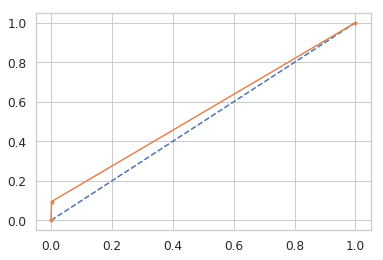

In [64]:
# Split
x, x_test, y, y_test = train_test_split(merged_train_df, target_df, test_size=0.001, random_state=42, stratify=target_df)

# For ROC

probability = logreg.predict(x_test)
auc = roc_auc_score(y_test, probability)
print('AUC: %.3f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probability)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

### **Light GBM**

In [65]:
# Train Model

x, x_test, y, y_test = train_test_split(merged_train_df, target_df, test_size=0.001, random_state=42, stratify=target_df)

categorical_features = [c for c, col in enumerate(merged_train_df.columns) if 'cat' in col]
train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(x_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

lgbm_model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=5000,
                       early_stopping_rounds=100)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.879282
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.892189
[3]	valid_0's auc: 0.892189
[4]	valid_0's auc: 0.891938
[5]	valid_0's auc: 0.895572
[6]	valid_0's auc: 0.897118
[7]	valid_0's auc: 0.901838
[8]	valid_0's auc: 0.906182
[9]	valid_0's auc: 0.905681
[10]	valid_0's auc: 0.903592
[11]	valid_0's auc: 0.902339
[12]	valid_0's auc: 0.903342
[13]	valid_0's auc: 0.904177
[14]	valid_0's auc: 0.903425
[15]	valid_0's auc: 0.90447
[16]	valid_0's auc: 0.907561
[17]	valid_0's auc: 0.909566
[18]	valid_0's auc: 0.909398
[19]	valid_0's auc: 0.911654
[20]	valid_0's auc: 0.911779
[21]	valid_0's auc: 0.915288
[22]	valid_0's auc: 0.91604
[23]	valid_0's auc: 0.917544
[24]	valid_0's auc: 0.917962
[25]	valid_0's auc: 0.917794
[26]	valid_0's auc: 0.918296
[27]	valid_0's auc: 0.917962
[28]	valid_0's auc: 0.919048
[29]	valid_0's auc: 0.919131
[30]	valid_0's auc: 0.918964
[31]	valid_0's auc: 0.919799
[32]	valid_0's auc: 0.920468
[33]	valid_0's auc: 

In [0]:
# Prediction
lgbm_predict = lgbm_model.predict(merged_test_df)

In [0]:
# Submission
lgbm_output = pd.DataFrame({'TransactionID': Tid, 'isFraud': lgbm_predict})
lgbm_output.to_csv("/content/drive/My Drive/lgbm.csv", index=False)

AUC: 0.9606


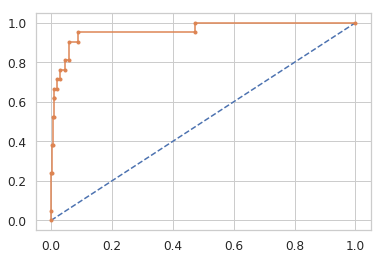

In [69]:
# For ROC

probability = lgbm_model.predict(x_test)
auc = roc_auc_score(y_test, probability)
print('AUC: %.4f' % auc)

fpr, tpr, thresholds = roc_curve(y_test, probability)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

### **AdaBoost**

In [74]:
# Train Model
train_X, test_X, train_y, test_y = train_test_split(merged_train_df, target_df, random_state=1)

adaboost_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200
)
adaboost_model.fit(train_X, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

In [0]:
# Prediction
adab_predict = adaboost_model.predict_proba(merged_test_df)[:,1]

In [0]:
# Submission
adab_output = pd.DataFrame({'TransactionID': Tid, 'isFraud': adab_predict})
adab_output.to_csv("/content/drive/My Drive/adaboost.csv", index=False)

AUC: 0.6282


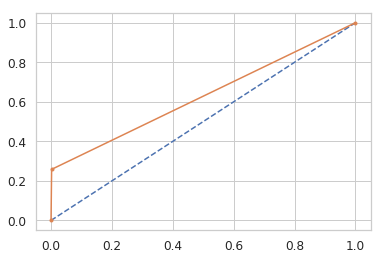

In [81]:
# For ROC

probability = adaboost_model.predict(test_X)
auc = roc_auc_score(test_y, probability)
print('AUC: %.4f' % auc)

fpr, tpr, thresholds = roc_curve(test_y, probability)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

## Part 7 - Final Result

Kaggle Link: https://www.kaggle.com/melitasaldanha

Highest Rank: 5077

Score: 0.8692

Number of entries: 4

Image of Kaggle Ranking:


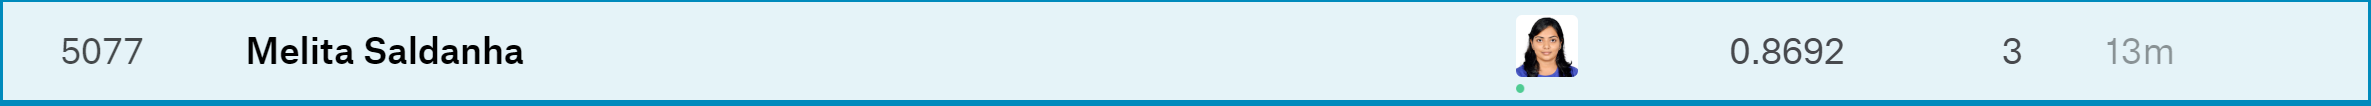

In [86]:
Image("/content/drive/My Drive/Fall 2019/CSE 519 - DSF/HW 2 - Fraud Detection/KaggleRank.png", width=1000)